<a href="https://colab.research.google.com/github/lrodrigocareaga/thesis/blob/master/MosquitoHybridModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [0]:
#General libraries needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
import keras,os,tarfile,sys,pickle,zipfile

#Keras libraries & packages
from keras import models,initializers,layers,optimizers
from keras import backend as K
from keras.utils import to_categorical,plot_model
from keras.models import Sequential,Model, load_model
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input,Dense,Conv2D,advanced_activations,Flatten,concatenate,Dropout,MaxPooling2D,Activation,GlobalAveragePooling2D,BatchNormalization,SeparableConv2D,SpatialDropout2D,LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input

#Sci-kit libraries
from sklearn import metrics
from sklearn.metrics import confusion_matrix,roc_auc_score, roc_curve, classification_report
from sklearn.model_selection import train_test_split,StratifiedKFold, KFold, ShuffleSplit
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer, MultiLabelBinarizer, LabelEncoder
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.datasets import make_regression

#Others
import time
import matplotlib.image as mpimg
import warnings
import skimage
import argparse
import locale
import glob
import sklearn.model_selection
import cv2
import shapely.wkt
import shapely.affinity
import seaborn as sns
from skimage.io import imshow
from shapely.geometry import MultiPolygon, Polygon
from collections import defaultdict
from shapely.wkt import loads as wkt_loads

Using TensorFlow backend.


In [0]:
# Establish the home directory
from google.colab import drive
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/mosquito')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
http://8a581489.ngrok.io


In [0]:
warnings.filterwarnings('ignore')

In [0]:
def avg(lst): 
    return sum(lst) / len(lst) 

# Experiments

## Load Data


In [0]:
def loadData(fileXls):

  #Numerical and Categorical columns needed in the data
  cols = ['collection_date','GPS_lat','GPS_lon','species','day','month','year','sample_count']

  #Source file
  df_info = pd.read_excel(fileXls)
  #Erase blank rows
  df_info = df_info.dropna()

  #Add year and month
  df_info['year'] = df_info['collection_date'].dt.year.astype(int)
  df_info['month'] = df_info['collection_date'].dt.month.astype(int)
  df_info['day'] = df_info['collection_date'].dt.day.astype(int)

  #filter the dataset
  df = df_info[cols]
  df = df.dropna()

  df['GENUS'] = df['species'].str.split(' ').str[0].astype(str)
  df['SPECIES'] = df['species'].str.split(' ').str[1].astype(str)
  df = df.rename(columns={"GPS_lat": "LATITUDE", "GPS_lon": "LONGITUDE"})

  df.sample_count = df.sample_count.astype(int)
  df['date'] = pd.to_datetime(df['collection_date'].dt.strftime('%d-%m-%Y'))

  del df['collection_date']
  del df['species']

  return df

In [0]:
#fileXls = '/content/drive/My Drive/mosquito/washington.xlsx'
fileXls = '/content/drive/My Drive/mosquito/Manatee.xlsx'
#fileXls = '/content/drive/My Drive/mosquito/Hernando.xlsx'
df = loadData(fileXls)

In [0]:
#Count of mosquitos trapped by ovitrap
def printInfo(df):
  countMonthK = df["month"].value_counts().keys().tolist()
  countMonth = df["month"].value_counts().tolist()
  print('Number of mosquitos captured by Month: ' + str(countMonthK))
  print('Number of mosquitos captured by Month: ' + str(countMonth))

  countYearK = df["year"].value_counts().keys().tolist()
  countYear = df["year"].value_counts().tolist()
  print('Number of mosquitos captured by Year: ' + str(countYearK))
  print('Number of mosquitos captured by Year: ' + str(countYear))

  countGenusK = df["GENUS"].value_counts().keys().tolist()
  countGenus = df["GENUS"].value_counts().tolist()
  print('Number of mosquitos captured by Genus: ' + str(countGenusK))
  print('Number of mosquitos captured by Genus: ' + str(countGenus))

  #DataFrame of number of mosquitos by trap
  traps_df = pd.DataFrame({'Genus' : countGenusK,
                         'Total' : countGenus},
                         columns=['Genus','Total'])

  print(traps_df.head())
  return 

In [0]:
#dataset of Washington Climate
def loadDataClimate(fileXlsClimate):

  df_climate = pd.read_excel(fileXlsClimate)

  df_climate['LATITUDE'] = df_climate['coordinates'].str.split(';').str[0].astype(float)
  df_climate['LONGITUDE'] = df_climate['coordinates'].str.split(';').str[1].astype(float)
  
  df_climate['date'] =  pd.to_datetime(df_climate['date'], format='%Y-%m-%d')
  df_climate['year'] = df_climate['date'].dt.year.astype(int)
  df_climate['month'] = df_climate['date'].dt.month.astype(int)
  df_climate['day'] = df_climate['date'].dt.day.astype(int)
  
  return df_climate


In [0]:
#fileXlsClimate = '/content/drive/My Drive/mosquito/weatherWashington.xlsx'
fileXlsClimate = '/content/drive/My Drive/mosquito/WeatherManateeFinal.xlsx'
#fileXlsClimate = '/content/drive/My Drive/mosquito/WeatherHernando.xlsx'
df_climate = loadDataClimate(fileXlsClimate)

In [0]:
#Merge of climate and mosquitos dataset
def mergeDatasets(df, df_climate):
  result = pd.merge(df, df_climate, how='inner', on=['year','month','day','LATITUDE','LONGITUDE'])
  result.head()

  #Export dataset to csv
  del result['date_x']
  del result['coordinates']
  result = result.rename(columns={"sample_count": "TOTAL", "date_y": "date"}) 
  result.TOTAL = result.TOTAL.astype(int)
  result.to_csv('result.csv',index=True)

  return result

In [0]:
result = mergeDatasets(df, df_climate)
print(result.head())
print(result.info())

    LATITUDE  LONGITUDE  day  ...  humidity  windSpeed  cloudCover
0  27.516317 -82.537735   22  ...      0.78       2.16        0.45
1  27.516317 -82.537735   22  ...      0.78       2.16        0.45
2  27.554018 -82.545481   22  ...      0.78       2.15        0.44
3  27.488870 -82.592140   22  ...      0.79       2.25        0.44
4  27.439449 -82.548928   22  ...      0.80       2.36        0.40

[5 rows x 20 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 64332 entries, 0 to 64331
Data columns (total 20 columns):
LATITUDE              64332 non-null float64
LONGITUDE             64332 non-null float64
day                   64332 non-null int64
month                 64332 non-null int64
year                  64332 non-null int64
TOTAL                 64332 non-null int64
GENUS                 64332 non-null object
SPECIES               64332 non-null object
date                  64332 non-null datetime64[ns]
precipType            64332 non-null int64
precipProbability    

## Take Outliers

In [0]:
def takeOutliers(result, percentile):
  result  = result.sort_values(by=['TOTAL'])
  numEntries = len(result.index)
  lowerBound = round(((1-percentile)/2),3)
  upperBound = 1-lowerBound
  print(lowerBound,' and ',upperBound)
  result = result.iloc[int((numEntries*lowerBound)):(int(numEntries*upperBound))]
  result.reindex(np.random.permutation(result.index))
  return result

In [0]:
result = takeOutliers(result, 0.7)
print(result.head())
print(result.info())

0.15  and  0.85
        LATITUDE  LONGITUDE  day  ...  humidity  windSpeed  cloudCover
57690  27.564967 -82.424886    9  ...      0.92       1.02        0.60
3462   27.475085 -82.551283   24  ...      0.82       1.62        0.10
51063  27.603067 -82.535717   18  ...      0.82       2.50        0.32
3463   27.475085 -82.551283   24  ...      0.82       1.62        0.10
58573  27.591467 -82.199850   20  ...      0.80       0.83        0.10

[5 rows x 19 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 45033 entries, 57690 to 13076
Data columns (total 19 columns):
LATITUDE              45033 non-null float64
LONGITUDE             45033 non-null float64
day                   45033 non-null int64
month                 45033 non-null int64
year                  45033 non-null int64
TOTAL                 45033 non-null int64
GENUS                 45033 non-null object
SPECIES               45033 non-null object
precipType            45033 non-null int64
precipProbability     45033 n

In [0]:
printInfo(result)

Number of mosquitos captured by Month: [8, 7, 6, 9, 10, 5, 11, 4, 12, 3, 2, 1]
Number of mosquitos captured by Month: [11109, 10999, 10842, 10429, 9985, 5500, 3564, 960, 636, 271, 26, 11]
Number of mosquitos captured by Year: [2014, 2013, 2016, 2015, 2012]
Number of mosquitos captured by Year: [14741, 13081, 12847, 12815, 10848]
Number of mosquitos captured by Genus: ['Culex', 'Aedes', 'Anopheles', 'Psorophora', 'Mansonia', 'Coquillettidia', 'Uranotaenia', 'Culiseta', 'Wyeomyia', 'BLANK', 'Culicidae', 'Culicinae', 'Orthopodomyia']
Number of mosquitos captured by Genus: [22134, 12108, 11349, 9557, 5542, 1605, 1251, 519, 108, 78, 72, 6, 3]
        Genus  Total
0       Culex  22134
1       Aedes  12108
2   Anopheles  11349
3  Psorophora   9557
4    Mansonia   5542


## Data Split

In [0]:
def xyFunc(result):
  del result['date']

  X = result.iloc[:, :].values
  y = result.iloc[:, 5].values

  # Transform categorical variables if needed
  labelencoder = LabelEncoder()
  X[:, 6] = labelencoder.fit_transform(X[:, 6])
  X[:, 7] = labelencoder.fit_transform(X[:, 7])
  #X[:, -1] = labelencoder.fit_transform(X[:, -1])
  scaler = MinMaxScaler(feature_range=(0, 1))
  X = scaler.fit_transform(X)
  #y = y/max(y)

  return X,y

In [0]:
X,y = xyFunc(result)

In [0]:
max(y)

54908

## Visualization

In [0]:
def boxPlotFunc(result):
  sns.boxplot(x='GENUS',y='TOTAL',data=result)
  plt.xlabel('GENUS')
  plt.ylabel('TOTAL')
  plt.title('Boxplot Graph')
  plt.tight_layout()
  plt.xticks(rotation='vertical')
  plt.figure(figsize=(15, 20))
  plt.savefig('/content/drive/My Drive/mosquito/resultsImages/box_Overall_Year.eps', format='eps', dpi=900)
  return plt.show()

In [0]:
def violinPlotFunc(result):
  sns.violinplot(x='GENUS',y='TOTAL',data=result,inner=None,color='lightgray')
  sns.stripplot(x='GENUS',y='TOTAL',data=result,size=10,jitter=True)
  plt.xlabel('GENUS')
  plt.ylabel('TOTAL')
  plt.title('Violin Graph')
  plt.xticks(rotation='vertical')
  plt.tight_layout()
  plt.figure(figsize=(15, 20))
  plt.savefig('/content/drive/My Drive/mosquito/resultsImages/viol_Overall_Year.eps', format='eps', dpi=900)
  return plt.show()

In [0]:
#Observe the correlation of the variables
def corrPlotFunc(result):
  corr = result.corr()
  corr.style.background_gradient()
  plt.figure(figsize=(10, 10))
  sns.heatmap(corr, cmap="RdYlGn_r", square= True, vmin=-1, vmax=1)
  plt.savefig('/content/drive/My Drive/mosquito/resultsImages/corr.eps', format='eps', dpi=900)
  # Display the heatmap
  return plt.show()

In [0]:
def evaluateModel(testX,testY,model):

  #evaluation of the model with test data 
  test_lossDense = model.evaluate(testX, testY)
  preds = model.predict(testX)

  diff = preds.flatten() - testY
  percentDiff = (diff / testY) * 100

  absPercentDiff = np.abs(percentDiff)
  absPercentDiff = absPercentDiff[absPercentDiff < 1E308]
  absPercentDiff = absPercentDiff[absPercentDiff > -1E308]
  
  mean = np.mean(absPercentDiff, dtype=np.float64)
  std = np.std(absPercentDiff, dtype=np.float64)

  print(mean)
  print(std)
  fig, ax = plt.subplots()
  ax.scatter(testY, preds)
  ax.plot([testY.min(), testY.max()], [testY.min(), testY.max()], 'k--', lw=4)
  ax.set_xlabel('Measured')
  ax.set_ylabel('Predicted')
  plt.show()

  return mean,std

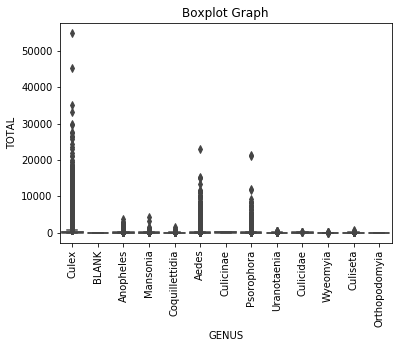

<Figure size 1080x1440 with 0 Axes>

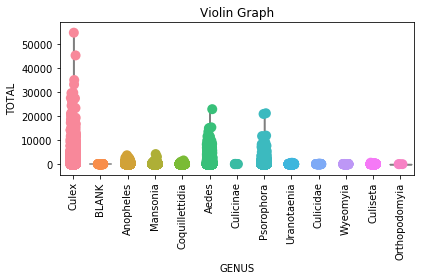

<Figure size 1080x1440 with 0 Axes>

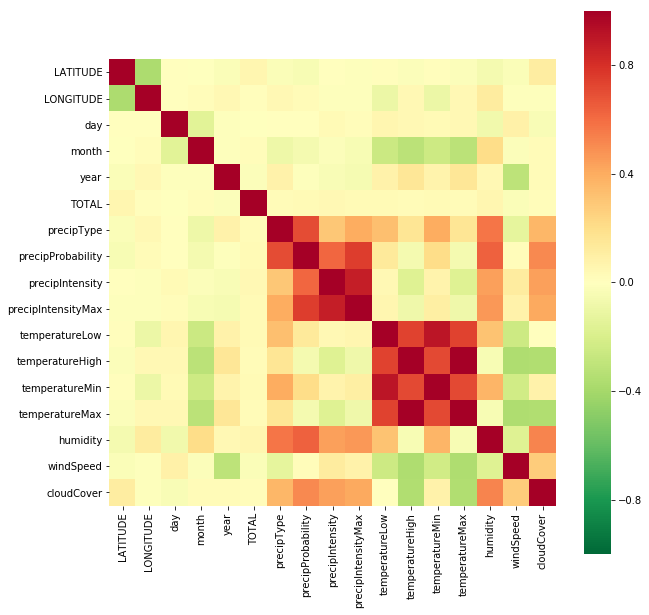

In [0]:
boxPlotFunc(result)
violinPlotFunc(result)
corrPlotFunc(result)

## SVM

In [0]:
# function to print SVM
def svmFunct(X,y):
  scoresCoef = []
  regrSVM = LinearSVR(random_state=0, tol=1e-5)
  cv = KFold(n_splits=10, random_state=1, shuffle=True)

  for train_index, test_index in cv.split(X):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    regrSVM.fit(X_train, y_train)
    y_pred = regrSVM.predict(X_test)
      
  print(regrSVM.coef_)
  print(regrSVM.intercept_)

  
  fig, ax = plt.subplots()
  ax.scatter(y_test, y_pred)
  ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
  ax.set_xlabel('True Values')
  ax.set_ylabel('Predicted')
  plt.savefig('SVM.eps', format='eps', dpi=900)

  return plt.show()

[ 0.08976804 -1.82988468 -0.13222964  2.94343464  3.5764762  27.87403952
 -1.99995339  0.43346255 -0.89461977  0.09257932  1.73183541 -0.20706991
 -0.17949801  1.59263707 -0.03313029  0.81647037  0.19935375  1.1440815 ]
[0.92371875]


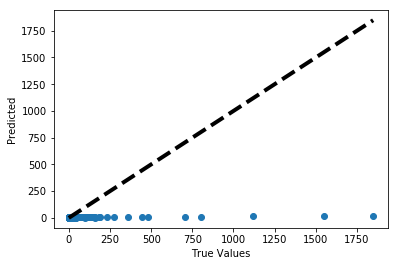

In [0]:
svmFunct(X,y)

## Linear Regression

In [0]:
def linearRegressionFunct(X,y):
  scoresCoef = []
  linreg = LinearRegression()
  cv = KFold(n_splits=10, random_state=1, shuffle=True)

  for train_index, test_index in cv.split(X):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    linreg.fit(X_train, y_train)
    y_pred = linreg.predict(X_test)
  
  print('Accuracy of linear regression classifier on test set: {:.2f}'.format(linreg.score(X_test,y_test)))
  #print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(linreg.score(testX, testY))
  print(linreg.coef_)
  print(linreg.intercept_)

  
  fig, ax = plt.subplots()
  ax.scatter(y_test, y_pred)
  ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
  ax.set_xlabel('True Values')
  ax.set_ylabel('Predicted')
  plt.savefig('linreg.eps', format='eps', dpi=900)

  return plt.show()

Accuracy of linear regression classifier on test set: 1.00
[-3.08896245e-14  2.48689958e-13 -2.51544829e-13 -1.38998010e-13
 -4.85718011e-13  4.94400000e+03 -1.68015182e-12 -1.38792723e-13
  1.25292176e-12  2.58034672e-12 -3.18176570e-12 -2.52239733e-12
 -1.26413900e-12  9.62739409e-13  3.71129730e-12 -3.69203419e-13
 -1.10142645e-12  9.06830167e-13]
-2.3803181647963356e-13


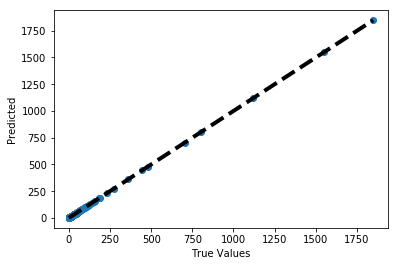

In [0]:
linearRegressionFunct(X,y)

## Hyperparameters

#### Dropout

In [0]:
dropout_10 = layers.Dropout(0.1,
               noise_shape=None,
               seed=1)

In [0]:
dropout_20 = layers.Dropout(0.2,
               noise_shape=None,
               seed=1)

In [0]:
dropout_50 = layers.Dropout(0.5,
               noise_shape=None,
               seed=1)

#### Lasso Regression

In [0]:
l1_reg10 = keras.regularizers.l1(0.001)

In [0]:
l1_reg20 = keras.regularizers.l1(0.2)

#### Ridge Regression

In [0]:
l2_reg10 = keras.regularizers.l2(0.1)

In [0]:
l2_reg20 = keras.regularizers.l2(0.2)

#### Lasso & Ridge

In [0]:
l1l2_reg = keras.regularizers.l1_l2(l1=0.01, l2=0.01)

### Batch Normalization

In [0]:
batch_normalization = layers.BatchNormalization(axis=-1, 
                                                momentum=0.999, 
                                                epsilon=0.0001, 
                                                center=True, 
                                                scale=True,
                                                beta_initializer='zeros', 
                                                gamma_initializer='ones', 
                                                moving_mean_initializer='zeros', 
                                                moving_variance_initializer='ones',
                                                beta_regularizer=None, 
                                                gamma_regularizer=None,
                                                beta_constraint=None,
                                                gamma_constraint=None)

### Custom Optimizers

In [0]:
adam_opt=optimizers.Adam(lr=0.001,
                   beta_1=0.9, 
                   beta_2=0.999,
                   epsilon=None,
                   decay=0.0,
                   amsgrad=False)

In [0]:
adadelta_opt = optimizers.Adadelta(lr=1.0,
                                   rho=0.95,
                                   epsilon=None,
                                   decay=0.0)

In [0]:
adadelta_opt = optimizers.Adadelta(lr=1.0,
                                   rho=0.95,
                                   epsilon=None,
                                   decay=0.0)

### Custom Activation Functions

In [0]:
leakyReLU_act = layers.LeakyReLU(alpha=0.3)

In [0]:
pReLU_act = layers.PReLU(alpha_initializer='zeros',
                         alpha_regularizer=None, 
                         alpha_constraint=None,
                         shared_axes=None)

In [0]:
elu_act = layers.ELU(alpha=1.0)

## Plot Functions

In [0]:
colorsList = ['b','g','r','m','y','c','k','w']
def lossTrainPlot(model_history):
  plt.title('Loss vs Epochs')
  for x in range(len(model_history)):
    plt.plot(model_history[x].history['loss'], label=('Training Fold ', x+1), color=colorsList[x])
  plt.legend()
  #plt.ylim(0,2)
  plt.savefig('/content/drive/My Drive/mosquito/resultsImages/lossPlot.eps', format='eps', dpi=900)
  return plt.show()

In [0]:
def lossValPlot(model_history):
  plt.title('Val Loss vs Epochs')
  for x in range(len(model_history)):
    plt.plot(model_history[x].history['val_loss'], label=('Val Fold ', x+1), color=colorsList[x])
  plt.legend()
  #plt.ylim(0,2)
  plt.savefig('/content/drive/My Drive/mosquito/resultsImages/ValPlot.eps', format='eps', dpi=900)
  return plt.show()

In [0]:
def lossTrainValPlot(model_history):
  plt.title('Train Loss vs Val Loss')
  for x in range(len(model_history)): 
    plt.plot(model_history[x].history['val_loss'], label=('Val Fold', x+1), color=colorsList[x])
    plt.plot(model_history[x].history['loss'], label=('Training Fold ', x+1), color=colorsList[x], linestyle = "dashdot")
  plt.legend(ncol=2)
  #plt.ylim(0,2)
  plt.savefig('/content/drive/My Drive/mosquito/resultsImages/lossValPlot.eps', format='eps', dpi=900)
  return plt.show()

## Multi-Layer Perceptron

In [0]:
model_checkpoint = ModelCheckpoint('RegMos.h5', verbose=1, save_best_only=True)

#model of dense neural network with 16, 8, 4 and 1 neurons in each layer respectively 
def create_mlp(dim, regress=False):
  model = Sequential()
  model.add(Dense(16, input_shape=(dim,),activation="relu"))
  model.add(Dense(8, activation="relu"))
  model.add(Dense(4, activation="relu"))
  
  if regress:
    model.add(Dense(1, activation="linear"))
  
  opt = Adam(lr=1e-3, decay=1e-3 / 200)
  model.compile(optimizer=opt, loss="mae", metrics=['mse'])
  
  return model



In [0]:
def kFoldMLP(X, y, folds=5, num_epochs=50, batch_size=16, verbose=True):
  all_scores = []
  model_history = [] 
  mean_List = []
  std_List = []
  start = time.clock()                 
  cv = KFold(n_splits=folds, random_state=1, shuffle=True)

  for train_index, test_index in cv.split(X):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]

    model = create_mlp(X_train.shape[1], regress=True)

    history = model.fit(X_train, y_train,validation_data=(X_test, y_test),
                        epochs=num_epochs,callbacks=[model_checkpoint,
                        TensorBoardColabCallback(tbc)], batch_size=batch_size, verbose=verbose)
    
    model_history.append(history)
    val_mape,val_mae = model.evaluate(X_test, y_test, verbose=0)
    all_scores.append(val_mape)

    mean, std = evaluateModel(X_test,y_test,model)
    print(mean)
    mean_List.append(mean)
    std_List.append(std)
    print(mean_List)
  
  plot_model(model, show_shapes = 1, to_file='DenseModel.png')
  model.summary()
  end = time.clock()
  timeDense = end-start
  #total time of training
  print("Total Time: {} ".format(timeDense)) 
  print("[INFO] avg. mosquito traped: {}, std mosquito trapped: {}".format((result['TOTAL'].mean()),(result['TOTAL'].std())))
  print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(avg(mean_List), avg(std_List)))
  return model, model_history, all_scores







Train on 51465 samples, validate on 12867 samples


Epoch 1/50
51465/51465 [==============================] - 15s 284us/step - loss: 226.1132 - mean_squared_error: 1060072.3421 - val_loss: 253.8196 - val_mean_squared_error: 1357070.4955

Epoch 00001: val_loss improved from inf to 253.81963, saving model to RegMos.h5
Epoch 2/50
51465/51465 [==============================] - 14s 267us/step - loss: 223.7035 - mean_squared_error: 1047008.4149 - val_loss: 250.0671 - val_mean_squared_error: 1331800.6115

Epoch 00002: val_loss improved from 253.81963 to 250.06709, saving model to RegMos.h5
Epoch 3/50
51465/51465 [==============================] - 14s 264us/step - loss: 217.8831 - mean_squared_error: 1000779.1239 - val_loss: 237.6702 - val_mean_squared_error: 1217456.2363

Epoch 00003: val_loss improved from 250.06709 to 237.67021, saving model to RegMos.h5
Epoch 4/50
51465/51465 [==============================] - 14s 264us/step - loss: 188.1357 - mean_squared_error: 756870.6839 - val_lo

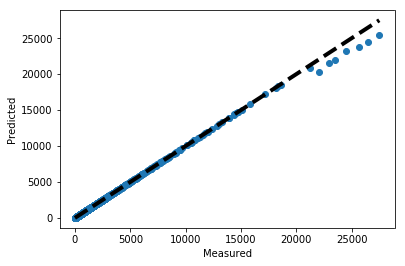

21.637439463174406
[21.637439463174406]
Train on 51465 samples, validate on 12867 samples
Epoch 1/50
51465/51465 [==============================] - 14s 266us/step - loss: 232.3255 - mean_squared_error: 1155675.4306 - val_loss: 229.1771 - val_mean_squared_error: 975154.6457

Epoch 00001: val_loss did not improve from 1.59207
Epoch 2/50
51465/51465 [==============================] - 14s 264us/step - loss: 229.6185 - mean_squared_error: 1141019.2128 - val_loss: 225.8255 - val_mean_squared_error: 953049.8837

Epoch 00002: val_loss did not improve from 1.59207
Epoch 3/50
51465/51465 [==============================] - 14s 262us/step - loss: 224.1630 - mean_squared_error: 1100121.1285 - val_loss: 216.8951 - val_mean_squared_error: 891669.2999

Epoch 00003: val_loss did not improve from 1.59207
Epoch 4/50
51465/51465 [==============================] - 13s 261us/step - loss: 206.2766 - mean_squared_error: 958966.0059 - val_loss: 186.8239 - val_mean_squared_error: 689812.2776

Epoch 00004: val_l

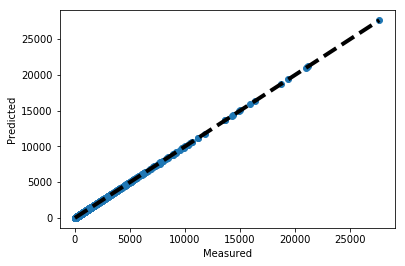

37.669672723468665
[21.637439463174406, 37.669672723468665]
Train on 51466 samples, validate on 12866 samples
Epoch 1/50
51466/51466 [==============================] - 14s 273us/step - loss: 238.3514 - mean_squared_error: 1162924.6453 - val_loss: 206.5704 - val_mean_squared_error: 952391.9539

Epoch 00001: val_loss did not improve from 0.59853
Epoch 2/50
51466/51466 [==============================] - 14s 268us/step - loss: 235.2044 - mean_squared_error: 1147165.6963 - val_loss: 201.4522 - val_mean_squared_error: 917028.8854

Epoch 00002: val_loss did not improve from 0.59853
Epoch 3/50
51466/51466 [==============================] - 14s 266us/step - loss: 220.2466 - mean_squared_error: 1030637.3475 - val_loss: 172.7379 - val_mean_squared_error: 698820.2283

Epoch 00003: val_loss did not improve from 0.59853
Epoch 4/50
51466/51466 [==============================] - 14s 265us/step - loss: 142.5395 - mean_squared_error: 503899.0448 - val_loss: 52.2956 - val_mean_squared_error: 117125.3323


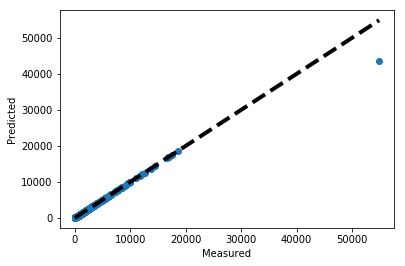

24.603912036192767
[21.637439463174406, 37.669672723468665, 24.603912036192767]
Train on 51466 samples, validate on 12866 samples
Epoch 1/50
51466/51466 [==============================] - 14s 274us/step - loss: 232.2994 - mean_squared_error: 1155994.8299 - val_loss: 229.5131 - val_mean_squared_error: 974725.6952

Epoch 00001: val_loss did not improve from 0.59853
Epoch 2/50
51466/51466 [==============================] - 14s 273us/step - loss: 229.4298 - mean_squared_error: 1139109.7929 - val_loss: 225.1124 - val_mean_squared_error: 943714.2482

Epoch 00002: val_loss did not improve from 0.59853
Epoch 3/50
51466/51466 [==============================] - 14s 273us/step - loss: 218.8651 - mean_squared_error: 1056579.6717 - val_loss: 203.3733 - val_mean_squared_error: 775586.6081

Epoch 00003: val_loss did not improve from 0.59853
Epoch 4/50
51466/51466 [==============================] - 14s 271us/step - loss: 163.1825 - mean_squared_error: 626956.6585 - val_loss: 96.1243 - val_mean_squared

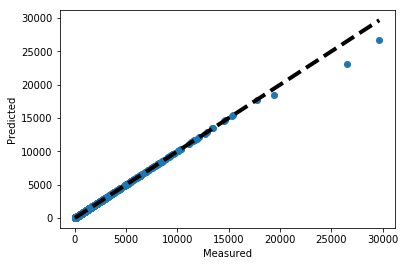

89.45650663817027
[21.637439463174406, 37.669672723468665, 24.603912036192767, 89.45650663817027]
Train on 51466 samples, validate on 12866 samples
Epoch 1/50
51466/51466 [==============================] - 14s 277us/step - loss: 230.8814 - mean_squared_error: 1069181.1907 - val_loss: 235.5509 - val_mean_squared_error: 1322142.2902

Epoch 00001: val_loss did not improve from 0.59853
Epoch 2/50
51466/51466 [==============================] - 14s 272us/step - loss: 228.7077 - mean_squared_error: 1057293.8979 - val_loss: 233.0495 - val_mean_squared_error: 1305369.4758

Epoch 00002: val_loss did not improve from 0.59853
Epoch 3/50
51466/51466 [==============================] - 14s 273us/step - loss: 224.8201 - mean_squared_error: 1027778.8777 - val_loss: 226.4353 - val_mean_squared_error: 1244689.1380

Epoch 00003: val_loss did not improve from 0.59853
Epoch 4/50
51466/51466 [==============================] - 14s 272us/step - loss: 210.8683 - mean_squared_error: 919177.9599 - val_loss: 197.6

In [0]:
#model, model_history, all_scores = kFoldMLP(X,y,folds=3, num_epochs=3,verbose=False)
model, model_history, all_scores = kFoldMLP(X,y)

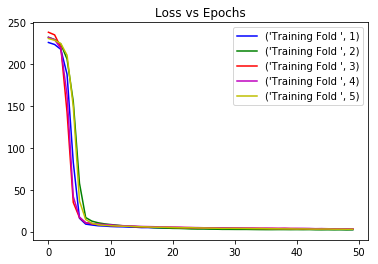

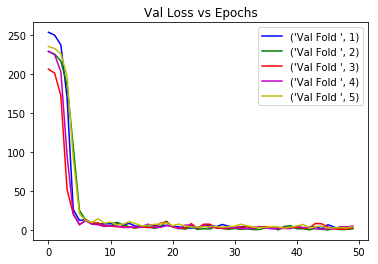

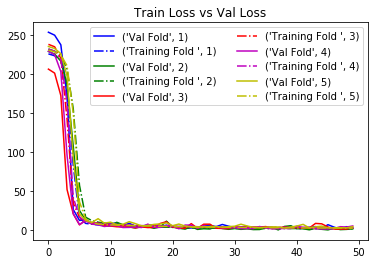

In [0]:
lossTrainPlot(model_history)
lossValPlot(model_history)
lossTrainValPlot(model_history)

In [0]:
def WeightsLayers(model):
  for layer in model.layers:
      weights = layer.get_weights()
  print(weights)
  return

In [0]:
WeightsLayers(model)

[array([[ 1.2569789],
       [-1.2410798],
       [-1.447251 ],
       [-1.4367872]], dtype=float32), array([0.29563618], dtype=float32)]


In [0]:
def loadBestModel(modelName):

  model = load_model(modelName)
  model.load_weights(modelName)
  print("Loaded model from disk")

  # evaluate loaded model on test data 
  # Define X_test & Y_test data first
  model.compile(loss='mean_absolute_percentage_error', optimizer='adam', metrics=['mape'])
  score = model.evaluate(testX, testY, verbose=0)
  print ("%s: %.2f%%" % (model.metrics_names[1], score[1]))
  preds = model.predict(testX)

  fig, ax = plt.subplots()
  ax.scatter(testY, preds)
  ax.plot([testY.min(), testY.max()], [testY.min(), testY.max()], 'k--', lw=4)
  ax.set_xlabel('Measured')
  ax.set_ylabel('Predicted')
  plt.show()
  return

In [0]:
'''modelName = 'RegMos.h5'
loadBestModel(modelName)'''

"modelName = 'RegMos.h5'\nloadBestModel(modelName)"

## Transfer Learning

### VGG19

In [0]:
def vgg19Model(width, height, depth):
  
  inputShape = (height, width, depth)
  base_modelVgg19=VGG19(weights='imagenet',
                        include_top=False,
                        input_shape=inputShape)

  model = Sequential()
  model.add(base_modelVgg19)
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(128, activation='linear'))
  model.add(layers.LeakyReLU(alpha=0.1))           
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='linear'))
  model.compile(optimizer='adam',loss='mae',metrics=['mse'])
  return model

In [0]:
start = time.clock() 
historyConvTransf = modelTransf.fit(x_train,train_small_with_dummies, 
                                    validation_data=(x_valid, train_small_with_dummies2),
                                    batch_size=128,verbose=2, nb_epoch=256,shuffle=True)

end = time.clock()
timeConvTL = end-start

print("Total Time: {} ".format(timeConvTL)) 

In [0]:
historyConvTransfDA = modelTransf.fit_generator(
        train_generator.flow(x_train, train_small_with_dummies, batch_size=32),
        steps_per_epoch=int(2*SIZE / 32),
        epochs=256,
        validation_data=evaluate_generator.flow(x_valid, train_small_with_dummies2, batch_size=32),
        validation_steps=128,
        verbose=2
    )

### ResNet 50

In [0]:
def resnet50Model(width, height, depth):
  
  inputShape = (height, width, depth)
  base_modelRes=ResNet50(weights='imagenet',
                        include_top=False,
                        input_shape=inputShape)

  model = Sequential()
  model.add(base_modelRes)
  model.add(Flatten())
  model.add(BatchNormalization())
  model.add(Dense(128, activation='linear'))
  model.add(layers.LeakyReLU(alpha=0.1))           
  model.add(Dropout(0.3))
  model.add(Dense(1, activation='linear'))
  model.compile(optimizer='adam',loss='mae',metrics=['mse'])
  return model

In [0]:
start = time.clock() 
historyRes = modelTransf2.fit(x_train,train_small_with_dummies, 
                                    validation_data=(x_valid, train_small_with_dummies2),
                                    batch_size=128,verbose=2, nb_epoch=256,shuffle=True)

end = time.clock()
timeRes = end-start

print("Total Time: {} ".format(timeRes)) 

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  after removing the cwd from sys.path.


Train on 1680 samples, validate on 420 samples
Epoch 1/256
 - 23s - loss: 1.6648 - acc: 0.5738 - val_loss: 7.2263 - val_acc: 0.3857
Epoch 2/256
 - 3s - loss: 0.9536 - acc: 0.7357 - val_loss: 12.0762 - val_acc: 0.1619
Epoch 3/256
 - 3s - loss: 0.6928 - acc: 0.8137 - val_loss: 11.9348 - val_acc: 0.1452
Epoch 4/256
 - 3s - loss: 0.4888 - acc: 0.8423 - val_loss: 8.9149 - val_acc: 0.1762
Epoch 5/256
 - 3s - loss: 0.5482 - acc: 0.8506 - val_loss: 5.6143 - val_acc: 0.3048
Epoch 6/256
 - 3s - loss: 0.5075 - acc: 0.8708 - val_loss: 10.5026 - val_acc: 0.1714
Epoch 7/256
 - 3s - loss: 0.2891 - acc: 0.9095 - val_loss: 3.9916 - val_acc: 0.4929
Epoch 8/256
 - 3s - loss: 0.2819 - acc: 0.9107 - val_loss: 5.2025 - val_acc: 0.5286
Epoch 9/256
 - 3s - loss: 0.3272 - acc: 0.9024 - val_loss: 5.6613 - val_acc: 0.3857
Epoch 10/256
 - 3s - loss: 0.2176 - acc: 0.9274 - val_loss: 4.9551 - val_acc: 0.4167
Epoch 11/256
 - 3s - loss: 0.1586 - acc: 0.9339 - val_loss: 5.8298 - val_acc: 0.4095
Epoch 12/256
 - 3s - lo

In [0]:
#ResNet with Data Augmentantion
historyResDA = modelTransf2.fit_generator(
        train_generator.flow(x_train, train_small_with_dummies, batch_size=32),
        steps_per_epoch=int(2*SIZE / 32),
        epochs=256,
        validation_data=evaluate_generator.flow(x_valid, train_small_with_dummies2, batch_size=32),
        validation_steps=128,
        verbose=2
    )

Epoch 1/256
 - 23s - loss: 3.3398 - acc: 0.2031 - val_loss: 5.3168 - val_acc: 0.2534
Epoch 2/256
 - 5s - loss: 2.7254 - acc: 0.3542 - val_loss: 7.9000 - val_acc: 0.2084
Epoch 3/256
 - 5s - loss: 2.5293 - acc: 0.3490 - val_loss: 7.7688 - val_acc: 0.2612
Epoch 4/256
 - 5s - loss: 2.3101 - acc: 0.3646 - val_loss: 5.9448 - val_acc: 0.3007
Epoch 5/256
 - 5s - loss: 2.2501 - acc: 0.4010 - val_loss: 4.3910 - val_acc: 0.2937
Epoch 6/256
 - 6s - loss: 2.4885 - acc: 0.4271 - val_loss: 6.8921 - val_acc: 0.1907
Epoch 7/256
 - 5s - loss: 2.5360 - acc: 0.4010 - val_loss: 9.0034 - val_acc: 0.1200
Epoch 8/256
 - 5s - loss: 2.7296 - acc: 0.3906 - val_loss: 7.0437 - val_acc: 0.1376
Epoch 9/256
 - 5s - loss: 2.5865 - acc: 0.3360 - val_loss: 12.2159 - val_acc: 0.0786
Epoch 10/256
 - 5s - loss: 2.5090 - acc: 0.3958 - val_loss: 14.1588 - val_acc: 0.0315
Epoch 11/256
 - 5s - loss: 3.2651 - acc: 0.2552 - val_loss: 15.4258 - val_acc: 0.0315
Epoch 12/256
 - 6s - loss: 2.8837 - acc: 0.2760 - val_loss: 15.3174 - 

### Transfer Learning ResNet

In [0]:
'''modelTransf2=ResNet50(weights=None,
                      include_top=True,
                      classes=1,
                      input_shape=(64,64,3))

modelTransf2 = Sequential()


modelTransf2.add(base_modelRes)
modelTransf2.add(Flatten())
modelTransf2.add(BatchNormalization())
modelTransf2.add(Dense(128, activation='linear'))
modelTransf2.add(layers.LeakyReLU(alpha=0.1))           
modelTransf2.add(Dropout(0.3))
modelTransf2.add(Dense(21, activation='softmax'))

modelTransf2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['categorical_accuracy'])'''

In [0]:
'''#ResNet50 Vainilla
start = time.clock() 
historyRes = modelTransf2.fit(trainImagesX, trainY, validation_data=(testImagesX, testY),epochs=200, batch_size=8)

end = time.clock()
timeRes = end-start

print("Total Time: {} ".format(timeRes)) '''

In [0]:
'''train_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=45,
        width_shift_range=0.05,
        height_shift_range=0.05,
        horizontal_flip=True,
        vertical_flip=True)

train_generator.fit(trainImagesX)
#ResNet with Data Augmentantion
historyResDA = modelTransf2.fit_generator(
        train_generator.flow(trainImagesX, trainY,epochs=200, batch_size=8),
        steps_per_epoch=int(2*SIZE / 32),
        epochs=256,
        validation_data=evaluate_generator.flow(testImagesX, testY), batch_size=32),
        validation_steps=128,
        verbose=2
    )'''

## Retrieve Images

In [0]:
def retrieveImages(result,inputPath,imgSize):
  start = time.clock() 

  images = []

  for i in result['LATITUDE']:
    basePath = os.path.sep.join([inputPath, "{},*".format(i)])
    imagePaths = sorted(list(glob.glob(basePath)))
    
    for imagePath in imagePaths:
      image = cv2.imread(imagePath)
      image = cv2.resize(image, (imgSize, imgSize))
      image = image.flatten()
      images.append(image)

  end = time.clock()
  timeImages = end-start

  print("Total Time: {} ".format(timeImages)) 
  images = np.array(images)
  images = images / 255.0
  print('X shape:', np.array(X).shape)
  print('y shape:', np.array(y).shape)
  print('images shape:', np.array(images).shape)
  return images

In [0]:
#inputPath = '/content/drive/My Drive/mosquito/imagesWashington'
inputPath = '/content/drive/My Drive/mosquito/imagesManatee'
#inputPath = '/content/drive/My Drive/mosquito/imagesHernando'
images = retrieveImages(result,inputPath,32)

Total Time: 271.650779 
X shape: (64332, 19)
y shape: (64332,)
images shape: (64332, 3072)


In [0]:
images

In [0]:
'''pd.DataFrame(images).to_csv("imagesManatee_128_80.csv", header=None, index=None)
start = time.clock() 
images = pd.read_csv("images_64.csv", header=None)
images = images.values
end = time.clock()
timeImages = end-start
print("Total Time: {} ".format(timeImages)) '''

## CNN with Images

In [0]:
model_checkpoint2 = ModelCheckpoint('RegMos2.h5', verbose=1, save_best_only=True)
def create_cnn(width, height, depth, filters=(16,32,64),regress=False):
  
  inputShape = (height, width, depth)
  chanDim = -1
  
  inputs = Input(shape=inputShape)
  
  for (i,f) in enumerate(filters):
    if i == 0:
      x = inputs
      
    x = Conv2D(f, (3,3), padding='same', kernel_regularizer='l2')(x)
    x = Activation ('relu')(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    
  x = Flatten()(x)
  x = Dense(16)(x)
  x = Activation('relu')(x)
  x = BatchNormalization(axis=chanDim)(x)
  x = Dropout(0.5)(x)
  
  x = Dense(4)(x)
  x = Activation('relu')(x)
  
  if regress:
    x = Dense(1,activation='linear')(x)
    
  model = Model(inputs,x)
  opt = Adam(lr=1e-3, decay=1e-3 / 200) 
  model.compile(optimizer=opt, loss="mae", metrics=['mse'])
  
  return model

In [0]:
def evaluateCNN(images,X,y,imgSize, folds=5, num_epochs=50, batch_size=16, verbose=True):
  all_scores = []
  model_history = [] 
  mean_List = []
  std_List = []
  start = time.clock()                 

  cv = KFold(n_splits=folds, random_state=1, shuffle=True)

  aug = ImageDataGenerator(rescale = 1./255, horizontal_flip = True,
                                   fill_mode = "nearest", zoom_range = 0.2,
                                   width_shift_range = 0.2, height_shift_range=0.2,
                                   shear_range=0.2, rotation_range=30) 
  
  for train_index, test_index in cv.split(X):

    X_train, X_test, y_train, y_test = images[train_index], images[test_index], y[train_index], y[test_index]
    
    X_train = X_train.reshape((X_train.shape[0], imgSize, imgSize, 3))
    X_test = X_test.reshape((X_test.shape[0], imgSize, imgSize, 3))

    model = create_cnn(imgSize, imgSize, 3, regress=True)
    #model = vgg19Model(imgSize, imgSize, 3)
    #model = resnet50Model(imgSize, imgSize, 3)

    history = model.fit(X_train, y_train,validation_data=(X_test, y_test),
                        epochs=num_epochs,callbacks=[model_checkpoint2,
                        TensorBoardColabCallback(tbc)], batch_size=batch_size, verbose=verbose)
    
    model_history.append(history)
    val_mape,val_mae = model.evaluate(X_test, y_test, verbose=0)
    all_scores.append(val_mape)

    mean,std = evaluateModel(X_test,y_test,model)

    mean_List.append(mean)
    std_List.append(std)
  

  '''with open('file.json', 'w') as f:
    json.dump(hist.history, f)'''
  plot_model(model, show_shapes = 1, to_file='CNNModel.png')
  model.summary()
  end = time.clock()
  timeDense = end-start
  #total time of training
  print("Total Time: {} ".format(timeDense)) 
  print("[INFO] avg. mosquito traped: {}, std mosquito trapped: {}".format((result['TOTAL'].mean()),(result['TOTAL'].std())))
  print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(avg(mean_List), avg(std_List)))
  return model, model_history, all_scores

In [0]:
#model2, model_history2, all_scores2 = evaluateCNN(images,X,y, 64, folds=3, num_epochs=3, batch_size=16, verbose=True)
model2, model_history2, all_scores2 = evaluateCNN(images,X,y,32)

In [0]:
lossTrainPlot(model_history2)
lossValPlot(model_history2)
lossTrainValPlot(model_history2)

In [0]:
WeightsLayers(model2)

[array([[ 0.5833018 ],
       [ 0.10444662],
       [-0.18700325],
       [ 0.45983508]], dtype=float32), array([1.3516402], dtype=float32)]


## Combine the models

In [0]:
model_checkpoint3 = ModelCheckpoint('RegMos3.h5', verbose=1, save_best_only=True)
def hybridModel(X_train,imgSize):
  mlp = create_mlp(X_train.shape[1], regress=False)
  cnn = create_cnn(imgSize, imgSize, 3, filters=(16,32,64),regress=False)

  combinedInput = concatenate([mlp.output, cnn.output])

  x = Dense(8, activation="relu")(combinedInput)
  x = Dense(4, activation="relu")(x)
  x = Dense(1, activation="linear")(x)

  modelF = Model(inputs=[mlp.input, cnn.input], outputs=x)

  opt = Adam(lr=1e-3, decay=1e-3 / 200)
  modelF.compile(optimizer=opt, loss="mae", metrics=['mse'])
  
  return modelF

In [0]:
def evaluateHybrid(images,X,y,imgSize=64, folds=5, num_epochs=50, batch_size=16, verbose=True):
  all_scores = []
  model_history = [] 
  mean_List = []
  std_List = []
  start = time.clock()                 

  cv = KFold(n_splits=folds, random_state=1, shuffle=True)

  aug = ImageDataGenerator(rescale = 1./255, horizontal_flip = True,
                                   fill_mode = "nearest", zoom_range = 0.2,
                                   width_shift_range = 0.2, height_shift_range=0.2,
                                   shear_range=0.2, rotation_range=30) 

  
  for train_index, test_index in cv.split(X):

    X_train, X_trainImages, X_test, X_testImages, y_train, y_test = X[train_index], images[train_index], X[test_index], images[test_index], y[train_index], y[test_index]

    X_trainImages = X_trainImages.reshape((X_train.shape[0], imgSize, imgSize, 3))
    X_testImages = X_testImages.reshape((X_test.shape[0], imgSize, imgSize, 3))
    
    model = hybridModel(X_train,imgSize)
    
    history = model.fit([X_train, X_trainImages], y_train, validation_data=([X_test, X_testImages],y_test),epochs=num_epochs,callbacks=[model_checkpoint3, TensorBoardColabCallback(tbc)], batch_size=16, verbose=1)

    model_history.append(history)
    val_mape,val_mae = model.evaluate([X_test, X_testImages], y_test, verbose=0)
    all_scores.append(val_mape)

    mean,std = evaluateModel([X_test, X_testImages],y_test,model)

    mean_List.append(mean)
    std_List.append(std)
  
  plot_model(model, show_shapes = 1, to_file='HybridModel.png')
  model.summary()
  end = time.clock()
  timeDense = end-start
  #total time of training
  print("Total Time: {} ".format(timeDense)) 
  print("[INFO] avg. mosquito traped: {}, std mosquito trapped: {}".format((result['TOTAL'].mean()),(result['TOTAL'].std())))
  print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(avg(mean_List), avg(std_List)))
  return model, model_history, all_scores

In [0]:
model3, model_history3, all_scores3 = evaluateHybrid(images,X,y,imgSize=64)

In [0]:
lossTrainPlot(model_history3)
lossValPlot(model_history3)
lossTrainValPlot(model_history3)

In [0]:
def lossKfold3Models(model_history,model_history3):
  # plot with various axes scales
  plt.figure(figsize=(20, 10))


  plt.subplot(321)
  plt.plot(model_history[0].history['loss'], label='Numerical & categorical')
  plt.plot(model_history2[0].history['loss'], label='Satellite Imagery')
  plt.plot(model_history3[0].history['loss'], label='Combined')
  plt.ylabel('Loss')
  plt.legend( loc='lower left')
  plt.title('1st Fold')
  plt.grid(True)

  plt.subplot(322)
  plt.plot(model_history[1].history['loss'], label='Numerical & categorical')
  plt.plot(model_history2[1].history['loss'], label='Satellite Imagery')
  plt.plot(model_history3[1].history['loss'], label='Combined')
  plt.ylabel('Loss')
  plt.legend( loc='lower left')
  plt.title('2nd Fold')
  plt.grid(True)

  plt.subplot(323)
  plt.plot(model_history[2].history['loss'], label='Numerical & categorical')
  plt.plot(model_history2[2].history['loss'], label='Satellite Imagery')
  plt.plot(model_history3[2].history['loss'], label='Combined')
  plt.ylabel('Loss')
  plt.legend( loc='lower left')
  plt.title('3rd Fold')
  plt.grid(True)

  plt.subplot(324)
  plt.plot(model_history[3].history['loss'], label='Numerical & categorical')
  plt.plot(model_history2[3].history['loss'], label='Satellite Imagery')
  plt.plot(model_history3[3].history['loss'], label='Combined')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend( loc='lower left')
  plt.title('4th Fold')
  plt.grid(True)

  plt.subplot(325)
  plt.plot(model_history[4].history['loss'], label='Numerical & categorical')
  plt.plot(model_history2[4].history['loss'], label='Satellite Imagery')
  plt.plot(model_history3[4].history['loss'], label='Combined')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend( loc='lower left')
  plt.title('5th Fold')
  plt.grid(True)

  plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                      wspace=0.35)
  plt.savefig('lossKfold3Models.eps', format='eps', dpi=900)

  return plt.show()

In [0]:
def valKfold3Models(model_history,model_history3):
  # plot with various axes scales
  plt.figure(figsize=(20, 10))


  plt.subplot(321)
  plt.plot(model_history[0].history['val_loss'], label='Numerical & categorical')
  plt.plot(model_history2[0].history['val_loss'], label='Satellite Imagery')
  plt.plot(model_history3[0].history['val_loss'], label='Combined')
  plt.ylabel('Validation Loss')
  plt.legend( loc='lower left')
  plt.title('1st Fold')
  plt.grid(True)

  plt.subplot(322)
  plt.plot(model_history[1].history['val_loss'], label='Numerical & categorical')
  plt.plot(model_history2[1].history['val_loss'], label='Satellite Imagery')
  plt.plot(model_history3[1].history['val_loss'], label='Combined')
  plt.ylabel('Validation Loss')
  plt.legend( loc='lower left')
  plt.title('2nd Fold')
  plt.grid(True)

  plt.subplot(323)
  plt.plot(model_history[2].history['val_loss'], label='Numerical & categorical')
  plt.plot(model_history2[2].history['val_loss'], label='Satellite Imagery')
  plt.plot(model_history3[2].history['val_loss'], label='Combined')
  plt.ylabel('Validation Loss')
  plt.legend( loc='lower left')
  plt.title('3rd Fold')
  plt.grid(True)

  plt.subplot(324)
  plt.plot(model_history[3].history['val_loss'], label='Numerical & categorical')
  plt.plot(model_history2[3].history['val_loss'], label='Satellite Imagery')
  plt.plot(model_history3[3].history['val_loss'], label='Combined')
  plt.ylabel('Validation Loss')
  plt.xlabel('Epoch')
  plt.legend( loc='lower left')
  plt.title('4th Fold')
  plt.grid(True)

  plt.subplot(325)
  plt.plot(model_history[4].history['val_loss'], label='Numerical & categorical')
  plt.plot(model_history2[4].history['val_loss'], label='Satellite Imagery')
  plt.plot(model_history3[4].history['val_loss'], label='Combined')
  plt.ylabel('Validation Loss')
  plt.xlabel('Epoch')
  plt.legend( loc='lower left')
  plt.title('5th Fold')
  plt.grid(True)

  plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                      wspace=0.35)
  
  plt.savefig('valKfold3Models.eps', format='eps', dpi=900)

  return plt.show()

In [0]:
lossKfold3Models(model_history,model_history3)

In [0]:
valKfold3Models(model_history, model_history3)

In [0]:
def boxPlots3Models(all_scores, all_scores2, all_scores3):

  ax1 = plt.subplot(131)
  plt.boxplot(all_scores)
  plt.title('MLP')
  plt.ylim(0, 6.5)
  #plt.setp(ax1.get_xticklabels(), fontsize=6)

  # share x only
  ax2 = plt.subplot(132, sharex=ax1)
  plt.boxplot(all_scores2)
  # make these tick labels invisible
  plt.title('CNN')
  plt.setp(ax2.get_xticklabels(), visible=False)

  # share x and y
  ax3 = plt.subplot(133)
  plt.boxplot(all_scores3)
  plt.ylim(0, 2.0)
  plt.title('Hybrid')
  plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                      wspace=0.35)
  plt.savefig('boxPlotsFinal.eps', format='eps', dpi=900)
  plt.show()

In [0]:
boxPlots3Models(all_scores, all_scores2, all_scores3)

## Sources

Source: 

[1] Cahill, Trey. (2019). Esri Story Maps: Fight the Bite, Protecting Washington, D.C. from Mosquito Borne Disease. 

[2] Giraldo-Calderón GI, Emrich SJ, MacCallum RM, Maslen G, Dialynas E, Topalis P, Ho N, Gesing S, VectorBase Consortium, Madey G, Collins FH, Lawson D. 2015. VectorBase: an updated bioinformatics resource for invertebrate vectors and other organisms related with human diseases. Nucleic Acids Research 43(Database issue):D707-13.

[3] Ehelepola, N. D. B., et al. "A study of the correlation between dengue and weather in Kandy City, Sri Lanka (2003-2012) and lessons learned." Infectious diseases of poverty 4.1 (2015): 42.

H. Ahmed E. and Moustafa M. (2016). House Price Estimation from Visual and Textual Features.In Proceedings of the 8th International Joint Conference on Computational Intelligence (IJCCI 2016)ISBN 978-989-758-201-1, pages 62-68. DOI: 10.5220/0006040700620068

https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

https://zoom.earth

In [0]:
'https://wtop.com/health-fitness/2016/06/trap-lab-dc-protects-residents-mosquito-borne-diseases/slide/1/'